In [14]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as mpl

from collections import defaultdict
from functools import reduce
from path import Path
from pprint import pprint
from statsmodels.tsa.stattools import adfuller

%matplotlib inline
mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 16,6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from sampling import dollar_bars
from filters import cusum
from multiprocess import mpPandasObj
from load_data import load_contracts
from labeling import getEvents, getVerticalBarriers, getBins
from util import getDailyVol

In [16]:
es_contracts = load_contracts('@ES')

In [17]:
def getWeights(d, size):
    # thresh > 0 drops insignificant weights
    w = [1.0]
    for k in range(1, size):
        w_ = -w[-1] / k * (d - k + 1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

def fracDiff(series, d, thres=0.01):
    '''
    Increasing width window, with treatment of NaNs
    Note: For thres=1, nothing is skipped.
    Note 2: d can be any positive fractional, not necessarily bounded [0,1]
    '''
    # 1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])
    # 2) Determine initial calcs to be skipped based on the weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_ > thres].shape[0]
    # 3) Apply weights to values
    df = {}
    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series(index=series.index) # bug in the original code
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            if not np.isfinite(series.loc[loc, name]):
                continue # exclude NAs
            a = w[-(iloc + 1):, :].T
            b = seriesF.loc[:loc]
            df_[loc] = np.dot(a, b)[0, 0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

def getWeights_FFD(d, thres):
    w, k = [1.0], 1
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
    return np.array(w[::-1]).reshape(-1, 1)

def fracDiff_FFD(series, d, thres=1e-5):
    # Constant with window (new solution)
    w =  getWeights_FFD(d, thres)
    width, df = len(w) - 1, {}
    
    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series(index=series.index)
        for iloc1 in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc1 - width], seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue # exclude NAs
            df_[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0, 0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

def plotMinFFD(instName):
    path = './'
    out = pd.DataFrame(columns=['adfStat', 'pVal', 'lags', 'nObs', '95% conf', 'corr'])
    df0 = pd.read_csv(path + instName + '.csv', index_col='date', parse_dates=True)
    for d in np.linspace(0, 1, 11):
        df1 = np.log(df0[['close_p']]).resample('1D').last() # downcast to daily obs
        df2 = fracDiff_FFD(df1, d, thres=0.01)
        corr = np.corrcoef(df1.loc[df2.index, 'close_p'], df2['close_p'])[0, 1]
        df2 = adfuller(df2['close_p'], maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr] # with critical value
        
    out[['adfStat', 'corr']].plot(secondary_y='adfStat')
    mpl.axhline(out['95% conf'].mean(), linewidth=1, color='r', linestyle='dotted')
    return


# 5.1a

Generate a time series from an IID Gaussian random process. This is a memory-less, stationary series:

Compute the ADF statistic on this series. What is the p-value?

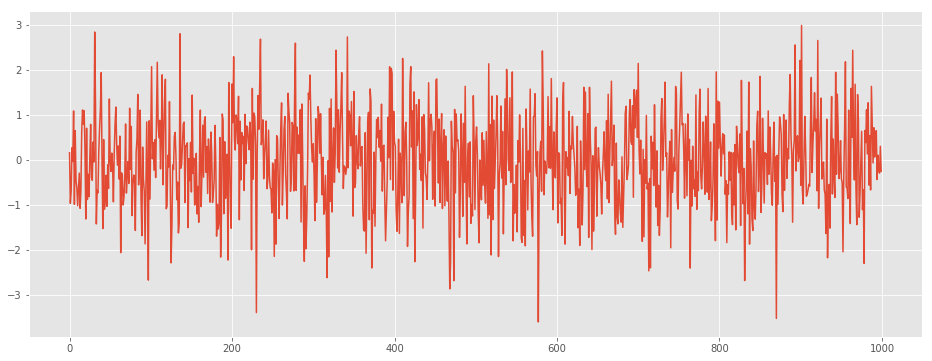

In [18]:
normal = pd.Series(np.random.normal(size=1000))
normal.plot();

In [19]:
from statsmodels.tsa.stattools import adfuller

print("P-Value:", adfuller(normal)[1])

P-Value: 0.0


# 5.1b

Generate a time series from an IID Gaussian random process. This is a memory-less, stationary series:

Compute the cumulative sum of the observations. This is a non-stationary series without memory.

1. What is the order of integration of this cumulative series?

2. Compute the ADF statistic on this series. What is the p-value?

In [20]:
n_cum = normal.cumsum()

print("P-Value:")
print(adfuller(n_cum)[1])

print("P-Value:")
print(adfuller(n_cum.diff().dropna())[1])

print("The order becomes stationary at first diff and is therefore integrated of order 1")
# TODO: Correct?

P-Value:
0.5860664648543601
P-Value:
0.0
The order becomes stationary at first diff and is therefore integrated of order 1


# 5.1c

Generate a time series from an IID Gaussian random process. This is a memory-less, stationary series:

Differentiate the series twice. What is the p-value of this over-differentiated series?

In [21]:
print("P-Value:")
print(adfuller(normal.diff().diff().dropna())[1])

P-Value:
4.192386960811389e-26


# 5.2a

Generate a time series that follows a sinusoidal function. This is a stationary series with memory.

Compute the ADF statistic on this series. What is the p-value?

P-Value:
0.0


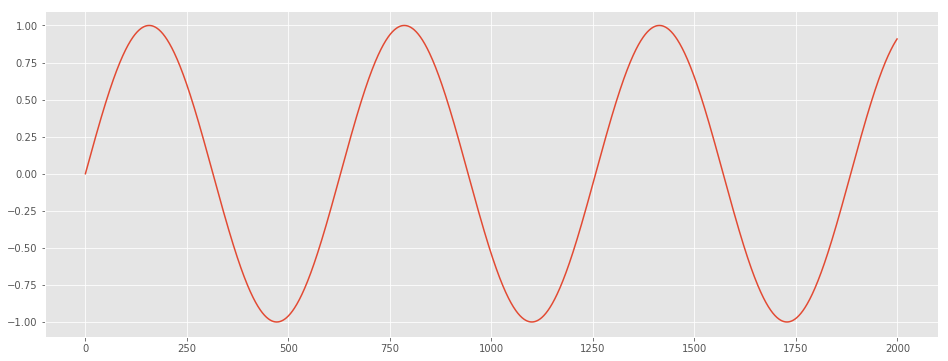

In [23]:
sin_index = np.arange(0, 20, 0.01)
orig_sine = pd.Series(np.sin(sin_index))
sinu = pd.DataFrame({'orig_sine': orig_sine})
orig_sine.plot()

print("P-Value:")
print(adfuller(sinu['orig_sine'])[1])

# 5.2b

Generate a time series that follows a sinusoidal function. This is a stationary series with memory.

Shift every observation by the same positive value. Compute the cumulative sum of the observations. This is a non-stationary series with memory.

1. Compute the ADF statistic on this series. What is the p-value?

2. Apply an expanding window fracdiff, $\tau = 1E - 2$. For what minimum d value do you get a p-value below 5%?

3. Apply FFD, with $\tau = 1E - 5$. For what minimum d value do you get a p-value below 5%?



P-Value:
0.9940889941295059


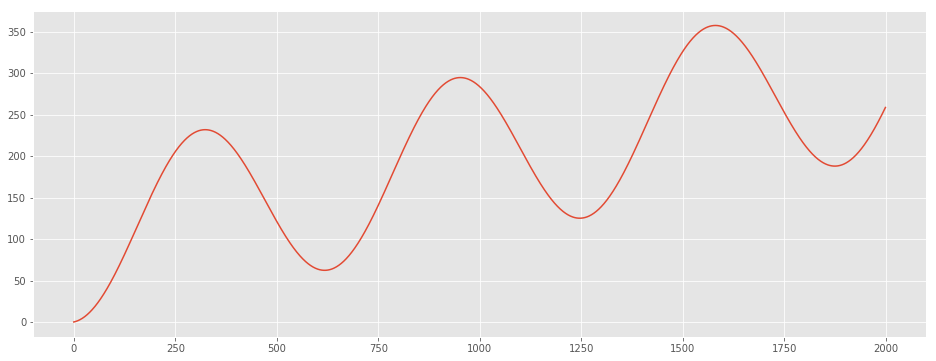

In [24]:
shifted_sinu = (orig_sine + .1).cumsum()
shifted_sinu.plot()

print("P-Value:")
print(adfuller(shifted_sinu)[1])

In [25]:
for d in np.arange(0, 1.0, 0.05):
    s = fracDiff(shifted_sinu.to_frame('s'), d)['s'].dropna()
    p_val = adfuller(s)[1]
    if p_val < 0.05:
        print("The minimum d value with a p-value below 5% is:")
        print(d)
        break


The minimum d value with a p-value below 5% is:
0.05


In [26]:
for d in np.arange(0.7, 1.0, 0.01):
    s = fracDiff(shifted_sinu.to_frame('s'), d, 1e-5)['s'].dropna()
        
    p_val = adfuller(s)[1]
    if p_val < 0.05:
        print("The minimum d value with a p-value below 5% is:")
        print(d)
        break


The minimum d value with a p-value below 5% is:
0.7


# 5.3a

Take the series from exercise 2.b

Fit the series to a sine function. What is the R-squared?

In [30]:
import numpy, scipy.optimize

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    # humbly re-appropriated from https://stackoverflow.com/a/42322656
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

res = fit_sin(sin_index, shifted_sinu)

R2 score: -5.055759640286628


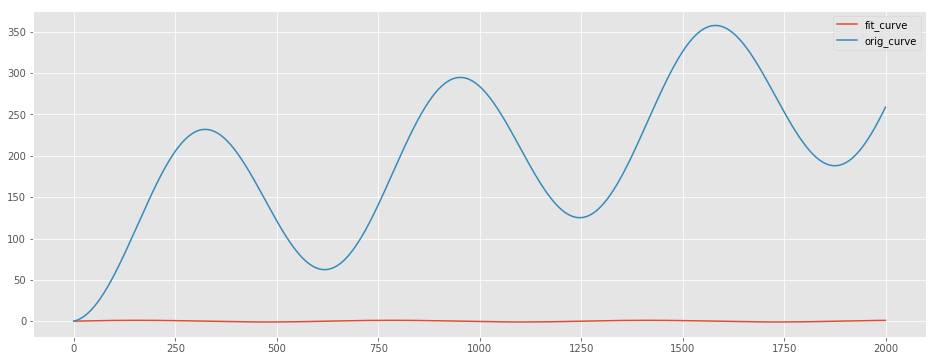

In [34]:
from sklearn.metrics import r2_score

fit_curve = pd.Series(res['fitfunc'](sin_index))
pd.DataFrame({'fit_curve': fit_curve, 'orig_curve': shifted_sinu}).plot()

print("R2 score:", r2_score(shifted_sinu, fit_curve))


# 5.3b

Take the series from exercise 2.b

Apply FFD(d = 1). Fit the series to a sine function. What is the R-squared?

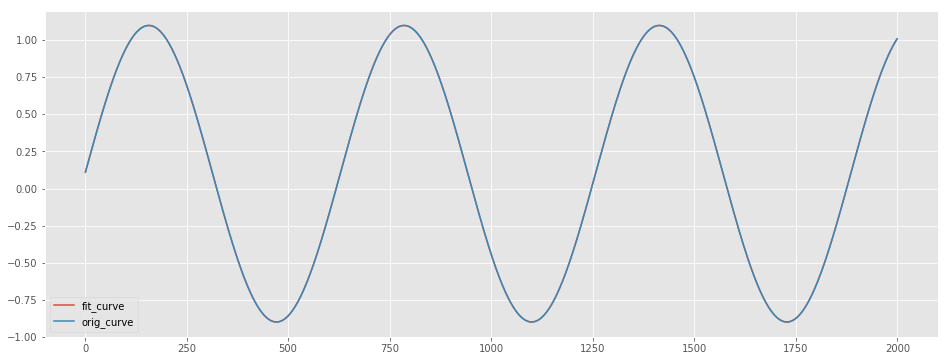

In [35]:
fracced = fracDiff_FFD(shifted_sinu.to_frame('s'), 1, 1e-5)['s']
df = pd.DataFrame({'index': sin_index, 'fracced': fracced.values}).dropna()

res = fit_sin(df['index'], df['fracced'])
fit_curve = pd.Series(res['fitfunc'](df['index']))
pd.DataFrame({'fit_curve': fit_curve, 'orig_curve': df['fracced']}).plot();

In [36]:
print("R2 score:", r2_score(df['fracced'], fit_curve))

R2 score: 0.9999999999999999


# 5.3c

Take the series from exercise 2.b

What value of d maximizes the R-squared of a sinusoidal fit on FFD(d). Why?

# 5.4

Take the dollar bar series on E-mini S&P 500 futures. Using the code in Snippet 5.3, for some $d \in [0, 2]$, compute `fracDiff_FFD(fracDiff_FFD(series, d), -d)`. What do you get? Why?

**A: An infinitely running process. Purportedly due to the illogical parameters we've passed in.**

# 5.5a

Take the dollar bar series on E-mini S&P 500 futures.

Form a new series as a cumulative sum of log-prices.


In [45]:
dbars = dollar_bars(es_contracts)
close = dbars['Close']
np_ret = np.log(close).diff()

# 5.5b

Take the dollar bar series on E-mini S&P 500 futures.

Apply FFD, with $\tau = 1E - 5$. Determine for what minimum $d \in [0, 2]$ the new series is stationary.

In [39]:
fracced = fracDiff_FFD(np_ret.to_frame('s'), 1, 1e-5)['s'].dropna()
adfuller(fracced)[1]

0.0

# 5.5c

Take the dollar bar series on E-mini S&P 500 futures.

Compute the correlation of the fracdiff series to the original (untransformed) series.

In [40]:
df = pd.concat({'fracced': fracced, 'orig': np_ret}, axis=1).dropna()
df.corr().iloc[0][1]

0.7050488711940517

# 5.5d

Take the dollar bar series on E-mini S&P 500 futures.

Apply an Engel-Granger cointegration test on the original and fracdiff series. Are they cointegrated? Why?

In [41]:
from statsmodels.tsa.stattools import coint
print("P-value", coint(df['fracced'], df['orig'])[1])

P-value 0.0


# 5.5e

Take the dollar bar series on E-mini S&P 500 futures.

Apply a Jarque-Bera normality test on the fracdiff series.

In [42]:
from scipy.stats import jarque_bera

print("P-value", jarque_bera(df['fracced'])[1])

P-value 0.0


# 5.6a

Take the fracdiff series from exercise 5.

Apply a CUSUM filter (Chapter 2), where h is twice the standard deviation of the series.

In [43]:
daily_vol = getDailyVol(close)
filtered_bars = cusum(df['fracced'], daily_vol.mean())


# 5.6b

Take the fracdiff series from exercise 5.

Use the filtered timestamps to sample a features' matrix. Use as one of the features the fracdiff value.

In [46]:
fracced_filtered_bars = fracDiff_FFD(dbars[dbars.index.isin(filtered_bars)][['Close']], 1)

In [47]:
fracced_filtered_bars.head()

,Close
2016-10-20 08:25:00,NaN
2016-11-11 10:21:00,90.00
2016-11-28 15:10:00,17.25
2016-12-05 06:48:00,0.75
2016-12-07 14:24:00,34.00


# 5.6c

Take the fracdiff series from exercise 5.

Form labels using the triple-barrier method, with symmetric horizontal barriers of twice the daily standard deviation, and a vertical barrier of 5 days.

In [48]:
t1 = getVerticalBarriers(df['fracced'], filtered_bars, numDays=5)
trip_barr_events = getEvents(df['fracced'], tEvents=filtered_bars, ptSl=[1,1], t1=t1, trgt=daily_vol * 2, minRet=0.01)
bins = getBins(trip_barr_events, df['fracced'])
bins['bin'].value_counts()

-1    1310
 1      61
Name: bin, dtype: int64

# 5.6d

Take the fracdiff series from exercise 5.

Fit a bagging classifier of decision trees where:

1. The observed features are bootstrapped using the sequential method from Chapter 4.
2. On each bootstrapped sample, sample weights are determined using the techniques from Chapter 4.